<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 8.2 MB 16.6 MB/s 


In [2]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [3]:
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [4]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
10194,поход отдел велосипедный банк пошутить,0
752,у он один есть реальный возможность прекратить...,1
14292,сказать что курилы российский,1
536,турецкий арабский хуесоса быть всё таки создат...,1
10651,при тот на не ставиться обвес как аццов нагиб ...,1
8564,на фермерский рынок всё равно никто не ходить ...,0
1515,я про целесообразность покупка новый лад веста...,0
10190,нафиг три релюха напряжение когда можно один т...,0
7727,ну я кошка тоже от рак умереть тоже вроде без ...,0
1191,дон табак приобрести компания входящий табачны...,0


In [5]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


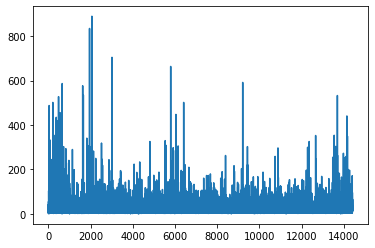

In [6]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [7]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)

In [9]:
X_train.shape

(11529,)

In [10]:
type(X_train)

numpy.ndarray

In [11]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [12]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [13]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [14]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [15]:
sequence_length

28

In [16]:
navec.get('<unk>').shape[0]

300

In [17]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [18]:
X_train.shape

(11529, 28, 300)

**Build RNN model**

Model: "Glove-Navec_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_2 (Spatia  (None, 28, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 28, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                

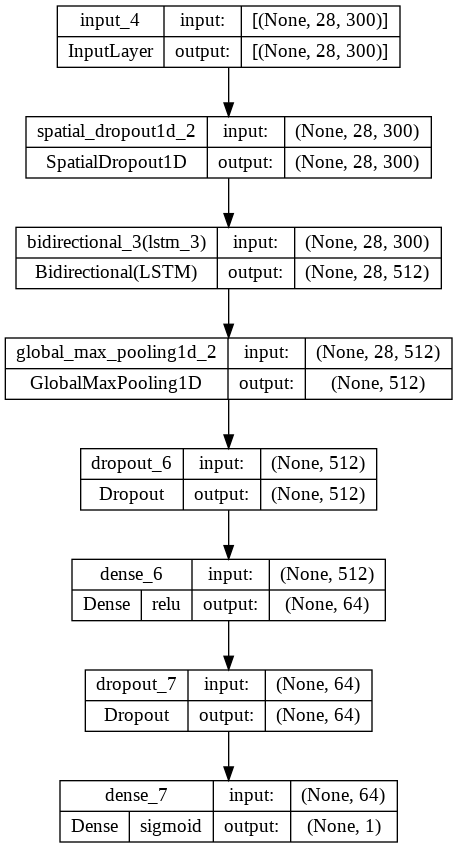

In [38]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_BiLSTM'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/20
19/19 [==============================] - 63s 3s/step - loss: 0.5347 - tp: 1973.0000 - fp: 1139.0000 - tn: 4948.0000 - fn: 1163.0000 - accuracy: 0.7504 - precision: 0.6340 - recall: 0.6291 - auc: 0.8130 - prc: 0.7084 - val_loss: 0.3394 - val_tp: 586.0000 - val_fp: 152.0000 - val_tn: 1403.0000 - val_fn: 165.0000 - val_accuracy: 0.8625 - val_precision: 0.7940 - val_recall: 0.7803 - val_auc: 0.9245 - val_prc: 0.8606
Epoch 2/20
19/19 [==============================] - 54s 3s/step - loss: 0.3676 - tp: 2613.0000 - fp: 768.0000 - tn: 5319.0000 - fn: 523.0000 - accuracy: 0.8600 - precision: 0.7728 - recall: 0.8332 - auc: 0.9220 - prc: 0.8585 - val_loss: 0.3308 - val_tp: 650.0000 - val_fp: 192.0000 - val_tn: 1363.0000 - val_fn: 101.0000 - val_accuracy: 0.8729 - val_precision: 0.7720 - val_recall: 0.8655 - val_auc: 0.9356 - val_prc: 0.8744
Epoch 3/20
19/19 [==============================] - 55s 3s/step - loss: 0.3286 - tp: 2706.0000 - fp: 740.0000 - tn: 5347.0000 - fn: 430.0000 - accur

**Save model**

In [40]:
model.save(MODEL_NAME)

In [41]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 14s 147ms/step


In [42]:
pred

array([0.99855876, 0.00172806, 0.00812774, ..., 0.9964735 , 0.99802893,
       0.00822233], dtype=float32)

In [43]:
pred

array([0.99855876, 0.00172806, 0.00812774, ..., 0.9964735 , 0.99802893,
       0.00822233], dtype=float32)

In [44]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [45]:
pred

array([1, 0, 0, ..., 1, 1, 0])

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 90.77 %
Recall: 87.86 %
Precision: 84.44 %
F1-score: 86.12 % 

True Negatives:  1792
False Positives:  152
False Negatives:  114
True Positives:  825


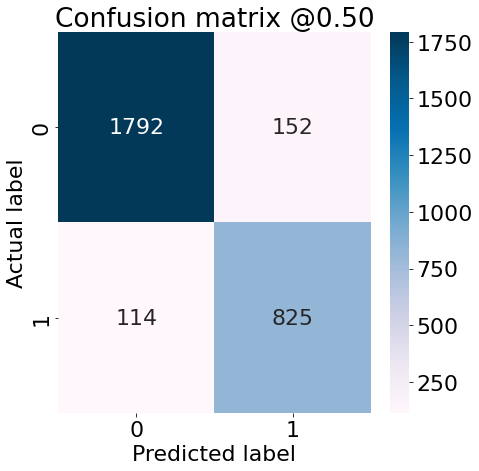

In [47]:
plot_cm(y_test, pred)

In [48]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

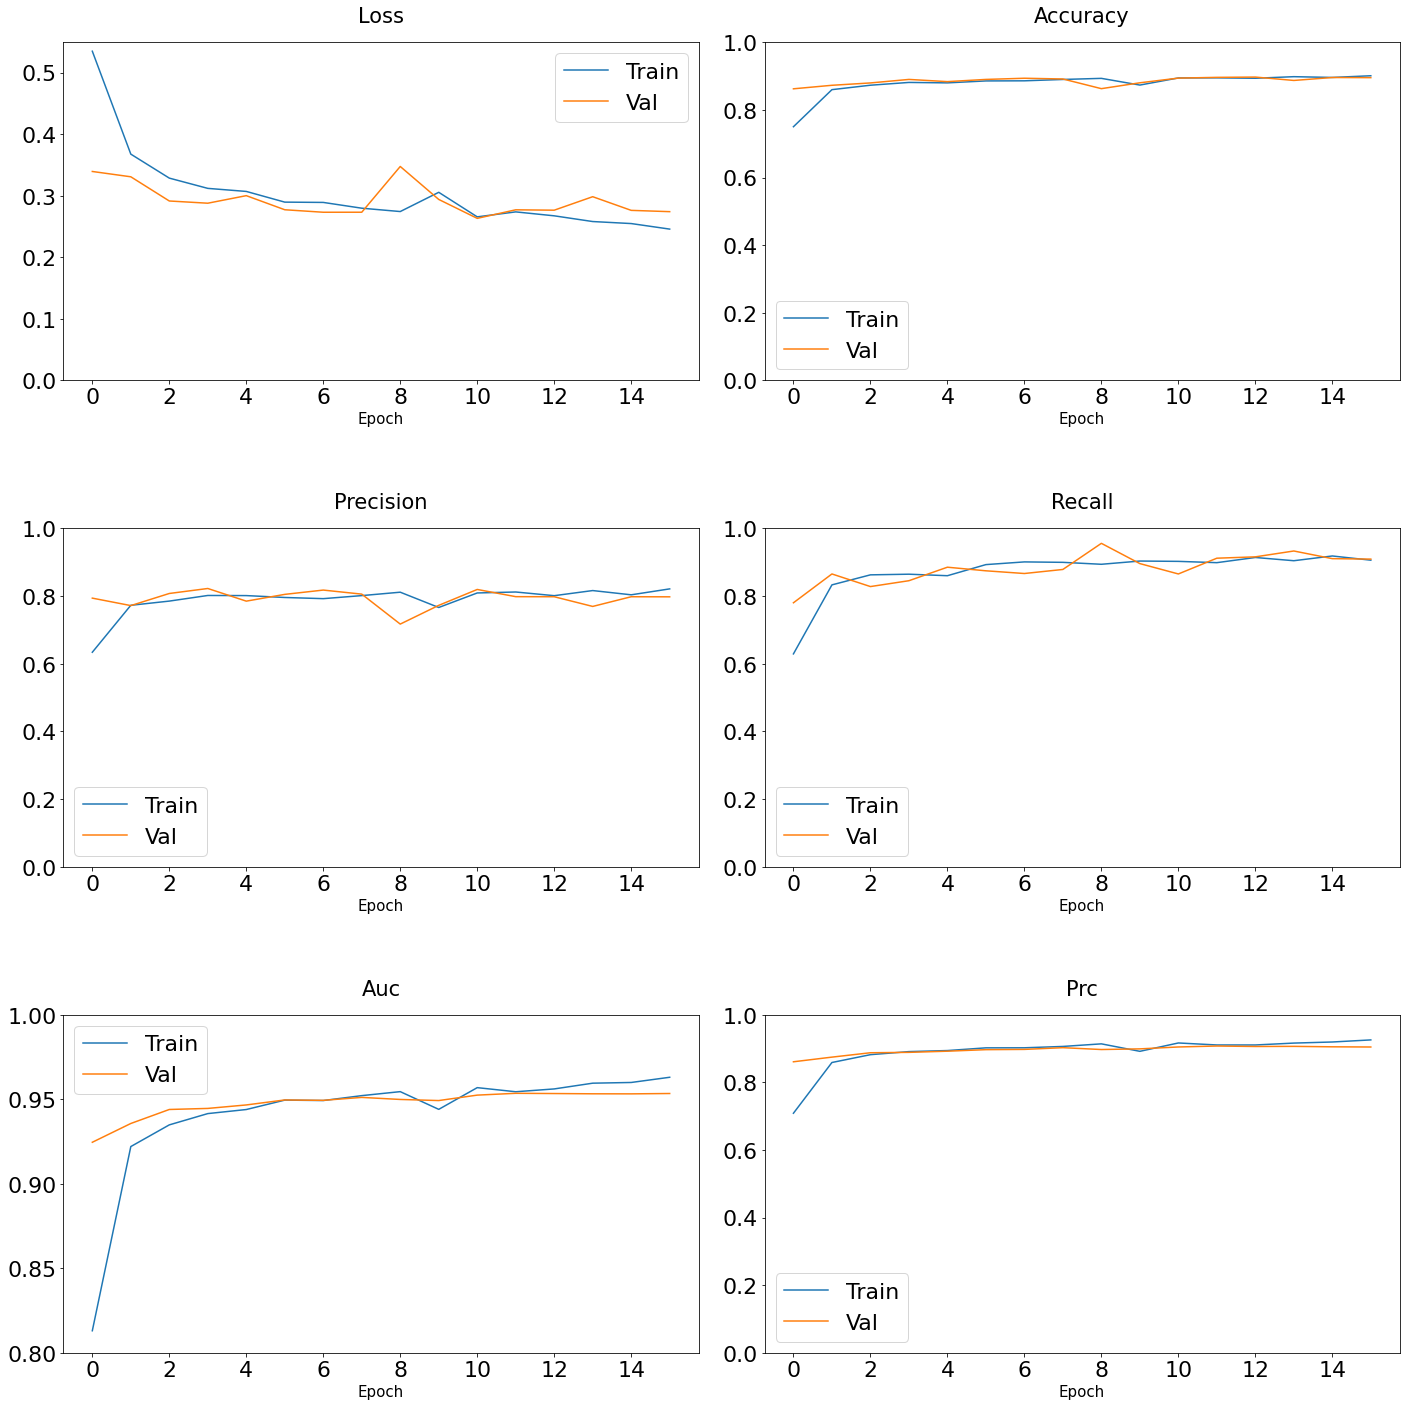

In [49]:
plot_metrics(history)

**Отобразим ROC - кривую**

91/91 [==============================] - 14s 149ms/step
: ROC AUC=0.958


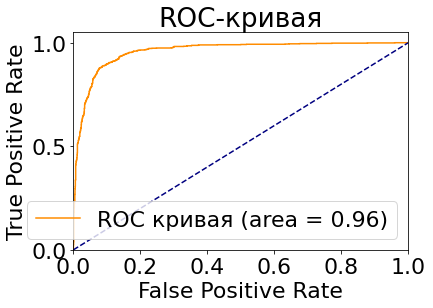

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()